https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/

Bagging classifiers is the best way to defeat over-fitting.

In [2]:
import matplotlib.pyplot as plt
from sklearn.exceptions import NotFittedError
import model.temporary.testing_k_folds as driver
from sklearn.metrics import confusion_matrix
import matplotlib as plt
import seaborn as sns
from model.multi_models import ModelWrapper

'''
- i = get classification probabilities
- determine the bins
- determine students that fit within their
respective bins
- determine those who are TP and FP
  (probably determined beforehand somehow)
- loop through student list, summing
  all the empirical risks and then getting
  the mean
- Plot

- The empirical risk curve will most likely
  not resemble the paper, so there might
  need to be changes.
'''

model_pipeline, X_test, y_test = driver.get_model_pipeline()
print('done')

Number of students on reduced lunch: 23
<class 'pandas.core.frame.DataFrame'>
Scoring used:  recall
Best parameters:  {}
Best/Mean score using best parameters:  0.41666666666666663
[[7 1]
 [1 7]]
Percentage:  0.875
16
done


Each bin object in the bins array will hold information regarding the
distribution of students. More than that, it will hold information regarding
the number of true positives out of the true positive and negatives.

In [4]:
class Bin:
    total_instances = 0
    real_positives = 0
    upper_range = 0
    lower_range = 0
    index = 0
    empirical_risk = 0

    def __init__(self, index, number_of_bins):
        ranges = 1 / number_of_bins
        self.upper_range = (index+1) * ranges
        self.lower_range = (self.upper_range - ranges) - 0.001
        self.index = index

    def add_student(self, is_real_positive):
        self.total_instances += 1

        if is_real_positive:
            self.real_positives += 1

        self.empirical_risk = self.real_positives / self.total_instances

number_of_bins_test = 4
bins_test = [Bin(x, number_of_bins_test) for x in range(0,number_of_bins_test)]

def add_to_bin(bin_array, probability, actual_positive):
    """
    The purpose of add_to_bin is to initialize the bin objects
    in a list. It does not create the bin object in the list itself.

    :param bin_array: list of correctly initialized bin objects
    :param probability: the risk score of the student
    :param actual_positive: whether the student is actually positive
    :return:
    """
    if len(bin_array) == 0 or type(bin_array[0]) is not ModelWrapper:
        raise ValueError("Bin array was not initialized correctly")

    if probability > 1 or probability < 0:
        raise ValueError("Probability must be in range (0, 1)")
    
    for k in bin_array:
        #bins encompass values of lower range <= x < upper_range
        if probability < k.upper_range:
            k.add_student(actual_positive)
            return

        # special case where one's determined probability IS one
        if probability == 1 and k.upper_range == 1:
            k.add_student(actual_positive)
            return

    raise RuntimeError("Could not find bin for a student. Bin array was \
                       initialized wrongly")

## Tests ##
add_to_bin(bins_test, 0.11, True)
add_to_bin(bins_test, 0.276, True)
add_to_bin(bins_test, 0.25, True)

assert bins_test[0].total_instances == 1
assert bins_test[1].total_instances == 2

In [5]:
import numpy as np

predictions = []
# contain student info and their probability in order to sort them
student_prediction_list = []
y_pred = [] #this is for the confusion matrix

# At this point, the model has not predicted any students yet.
# The loop goes through the X_test array and allows the model
# to individually predict each student. This is done in order
# to get individual information about each data point prediction.
# With a simple prediction list, you cannot know whether
# the student is a false or true positive because row numbers
# of nparrays and dataframes do not align for some reason.
for i in range(X_test.shape[0]):
    student_data_point = X_test.iloc[i].values.reshape(1,-1)
    pred = model_pipeline.predict(student_data_point)
    y_pred_prob = model_pipeline.best_estimator_['model'].predict_proba(student_data_point)[:, 1]

    #whether a student was positive, regardless if false positive or true positive
    student_actually_positive = y_test.iloc[i] == True

    predictions.append({"prediction": pred[0],
                        "student_actually_positive": student_actually_positive,
                        "probability": y_pred_prob[0]})

    student_prediction_list.append({"student": student_data_point,
                                    "probability": y_pred_prob[0]})

    y_pred.append(pred)

matrix = confusion_matrix(y_test, np.asarray(y_pred).reshape(-1,1))
print(matrix)


#
number_of_bins = 4
#### INITIALIZING THE BIN ARRAY
bins = [Bin(x, number_of_bins)for x in range(0,number_of_bins)]

#COUNT NUMBER OF TRUE POSITIVES
count = 0
for i in predictions:
    if i['student_actually_positive']:
        count += 1

print(count)

for student_results in predictions:
    add_to_bin(bins, student_results['probability'], student_results['student_actually_positive'])

instances_count = 0
for i in bins:
    print("BIN %i" % i.index)
    instances_count += i.total_instances
    print("Instances: ", i.total_instances)
    print("Actual positives: ", i.real_positives)
    print("Empirical Risk of Bin: ", i.empirical_risk)

print(instances_count)

student_prediction_list.sort(key=lambda x: x["probability"])

# for student in student_prediction_list:
#     print(student["student"])
#     print(student["probability"])
#     print("======")
#

<class 'pandas.core.frame.DataFrame'>
Int64Index([68, 77, 44, 27, 63, 73, 61, 55, 51, 34, 38, 33, 10, 59, 36, 2], dtype='int64')
A8                                      13.0
Has_504_No                               1.0
Has_504_Yes                              0.0
Student on Free or Reduced Lunch_No      0.0
Student on Free or Reduced Lunch_Yes     1.0
IEP/Specialized_No                       1.0
IEP/Specialized_Yes                      0.0
Name: 77, dtype: float64
<class 'pandas.core.series.Series'>
(16, 7)
[[7 1]
 [1 7]]
8
BIN 0
Instances:  7
Actual positives:  1
Empirical Risk of Bin:  0.14285714285714285
BIN 1
Instances:  1
Actual positives:  0
Empirical Risk of Bin:  0.0
BIN 2
Instances:  4
Actual positives:  3
Empirical Risk of Bin:  0.75
BIN 3
Instances:  4
Actual positives:  4
Empirical Risk of Bin:  1.0
16


In [8]:
class EmpiricalRiskModelWrapper:

    def __init__(self, classifier: ModelWrapper, amount_of_bins=4):
        if ModelWrapper.is_fit() is False:
            raise ValueError("Model must be fitted!")

        self.bins_initialized = False
        self.model_wrapper = classifier
        self.y_pred = []
        self.bins_of_models = [Bin(x, amount_of_bins) for x in range(0, amount_of_bins)]
        self.y_values = []

    def predict(self):
        return self.model_wrapper.predict()

    def get_prediction_info(self, X_test_, y_test_):
        """
        This function predicts each student individually while also
        obtaining extra information regarding the prediction that
        cannot be done with normal model.predict(X_test).

        :param X_test_: x_test
        :param y_test_: y_test
        :return: predictions with extra useful information
        """
        for j in range(X_test_.shape[0]):
            data_point = X_test_.iloc[j].values.reshape(1,-1)
            model_pred = self.model_wrapper.predict(data_point)
            y_pred_probability = \
                self.model_wrapper.best_estimator_['model'].predict_proba(data_point)[:, 1]

            #whether a student was positive, regardless if false positive or true positive
            positive_student = y_test_.iloc[j] == True

            predictions.append({"prediction": model_pred[0],
                                "positive_student": positive_student,
                                "probability": y_pred_probability[0]})

            student_prediction_list.append({"student": data_point,
                                            "probability": y_pred_probability[0]})

            y_pred.append(model_pred)
            self.y_pred = y_pred

        return self.y_pred

    def get_empirical_risk(self):
        """
        Calculates empirical risks done by a specific model

        :return: list of bins with their calculated mean empirical risk
        """

        if self.model_wrapper.is_fit() is False:
            raise NotFittedError()

        if len(self.y_pred) == 0:
            raise RuntimeError("get_prediction_info has not been called yet!")

        self.bins_initialized = True
        for results in self.y_pred:
            add_to_bin(self.bins_of_model,
                       results['probability'],
                       results['student_actually_positive'])

        for bin_ in self.bins_of_models:
            self.y_values.append(bin_.empirical_risk)

        return self.model_wrapper.model_name, self.bins_of_models, self.y_values


#################### GRAPHING EMPIRICAL RISK #######################

number_of_bins = 4
graph_x_values = []
graph_y_values = []

# initialize x_values for the graph
upper_range = 1 / number_of_bins
for i in range(0,number_of_bins):
    graph_x_values.append(upper_range)
    upper_range += upper_range


# contains empirical risk model wrapper objects
emp_model_wrapper = []

##TODO: X_TEST????? WHERE DOES IT COME FROM?

for model_wrapper in emp_model_wrapper:
    # initialize each model wrapper objec
    model_wrapper.get_predicted_info(X_test, y_test)

    # get empirical risk returns tuple. y_values are third in the tuple
    graph_y_values.append(model_wrapper.get_empirical_risk[2])

ax = sns.lineplot(x=graph_x_values, y=graph_y_values)

for y in graph_y_values:
    sns.lineplot(x=graph_x_values, y=y)

"""
8
6 3:05

"""

NameError: name 'ModelWrapper' is not defined

[0.14285714285714285, 0.0, 0.75, 1.0]


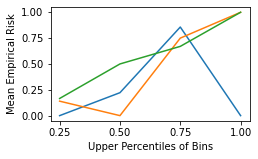

In [7]:

# Graphing mean empirical risk

y_values = [] # mean empirical risk of each bin
x_values = []
for i in bins:
    y_values.append(i.empirical_risk)
    x_values.append(i.upper_range)

print(y_values)


x_values = [0.25, 0.5, 0.75, 1]
y_values = [0, 0.222, 0.85714, 0]
# AdaBoost

# plt.pyplot.figure(figsize=(10,5))

ax = sns.lineplot(x=x_values, y=y_values)
ax.set_xlabel("Upper Percentiles of Bins")
ax.set_ylabel("Mean Empirical Risk")
ax.set_xticks([0.25, 0.5, 0.75, 1])

# Random Forest
y_values = [0.14, 0, 0.75, 1]
sns.lineplot(x=x_values, y=y_values)

# Linear Regression
y_values = [0.166, 0.5, 0.67, 1]
sns.lineplot(x=x_values, y=y_values)

fig = ax.get_figure()

width  = 3.5
height = width / 1.618
fig.subplots_adjust(left=.20, bottom=.24, right=.99, top=.97)
fig.set_size_inches(width, height)
fig.savefig('myimage.png')